# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

### Importing Libraries and Helper Functions



In [0]:
#!pip3 install tensorflow==2.1.0 pillow matplotlib
#!pip3 install git+https://github.com/am1tyadav/tfutils.git

In [22]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


### Importing and Plotting the Data

In [0]:
#tfutils function downloads the mnist datasets and preprocess it to normalize it as well as to unroll the examples
#Each mnist handwritten data is 28X28 image, having the pixel values from 0-255 which is normalized as well. 
#Using just the zeros 
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)
#Creating combined subset with axis=0 for rows
x = np.concatenate([x_train, x_test], axis=0)

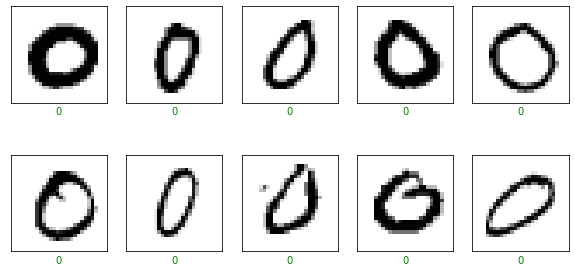

In [24]:
#Passing labels as 0 by creating a blank array essentially which has zeros.
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

# Discriminator

![Artist and Critic](artist_critic.png)

## Key Points
1. Implementing Discriminator of DCGAN.
2. GAN has two parts: Artist (Generator) and Critic (Discriminator).
3. Essentially the idea is, we train this model on real data as well as on image generated by the Generator (Artist).
4. Ofcourse initially, those generated images are quite bad in the sense that they don't look like real images at all and there will essentially be noise. And it will be pretty easy for the second part of the network which is the critic or Discriminator to classify incoming images as real or fake.
5. Once we train the network for a while, artist will become better at generating those images which will start to fool the critic and once the discriminator is fooled, since it's part of a network we are training it will also start to get better at recognizing the fake images.
6. So, there is this adversarial relationship between the artist and the critic and that's the key component of this idea of GANs.
7. So as we train the model more and more, the artist gets better at creating fake images which look like real images and the critic in return gets better at recognizing those fake images. So, after a few iterations you will start to see images which are reasonably close to how the real data looks like.

In [25]:
size = 28
noise_dim = 1
#Using sequential class from keras and passing the lists that we want
discriminator = Sequential([
    #This is a Convnet having total of 3 convolutional blocks.
    #First Conv2D layer of 64 filters, kernel size of 3 by 3, strides=2 and i/p shape to 28 by 28 by 1.
    #Our images are black and white so channel info is just going to be 1 not 3 & the rows and cols are 28 by 28.
    #Following the same ideas from the popular paper Unsupervised Representation Learning with DCGANs, 2015.
    #In the paper they don't use max_pooling to reduce the dimensions of these tensors, but here we are using strides=2 to reduce the dimensions instead of pooling.
    #Deeper layers have more filters and the dimensions w.r.t rows and cols is reduced with each conv block.
    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    #Flattening or unroll the i/p tensors to this image to a 2D tensor and connect a dense layer (output) which has activation set to sigmoid . 
    #In this case, it's a inappropriate choice because we are just looking at binary classification. The discriminator just needs to tell us whether the input image is real or fake.  
    Flatten(), 
    Dense(1, activation='sigmoid')
])

#And ofcourse, there is always an element of hit and trial when it comes to DL, but this is a reasonable discriminator given the data we have.
#Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#beta_1 : The exponential decay rate for the 1st moment estimates. Defaults to 0.9.
opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5) #lr=0.03663127777 but default is 0.001

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()
#Tensorflow backend is going to load cuda library behind the scenes.
#Tries to learn the features taking the image as 28X28 with these 3 conv blocks.
#After we have the 3 convblocks, our features are represented as a tensor of 256 and the first axis as batch size in Flatten o/p,
#which is then connected to the final o/p which is the dense layer with just one node which will give us either +ve or -ve classification 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 256)        

# Generator

In [26]:
#Go into the opposite direction till we get a tensor of 28X28X1 and that will be our generated image
generator = Sequential([
    #We are using scalar single value(256) instead of 128D vector as used in DCGAN paper, just to keep things simple and that value will be generated randomly.
    #And depending upon the value, the generator might create a slightly different image but the idea is that ultimately after the training irrespective of the i/p, it should still learn all the features that are required to create realistic images of the Handwritten digits 0.
    #With different values for the i/p that image might look a little different but it's still should be able to fool the discriminator into thinking that it's a real image 
    Dense(256, activation='relu', input_shape=(noise_dim,)),
    Reshape((1, 1, 256)), #Going the opposite way looking at the o/p
    
    Conv2DTranspose(256, 5, activation='relu'), #We can use conv2DTranspose to increase the row and col dimensions as we go further deeper into the network.
    BatchNormalization(),
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid') #Using just the single filter coz that will be our channel info, and kernel size of 4 bcoz we are already at 25 so 4 will do the work. 

])

generator.summary()
#conv2d_transpose_9 serving as our generated image of 28X28X1 taking only the scalar single i/p value

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_23 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_24 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 21, 21, 64)       

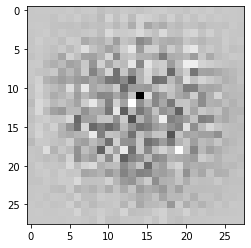

In [27]:
#Looking at an example what it generates at the moment. This part of out network is not trained at all. The generator doesn't know what it's supposed to generate.
#But, let's see the random output creating the noise with 1 for the batch size and 1 for the scalar value that we want for the i/p.
noise = np.random.randn(1, noise_dim)
gen_image = generator.predict(noise)[0] #Passing the noise with jsut the first element 1, so that will be 28X28X1 tensor.

plt.figure()
#The generated image is of shape 28X28X1. When we use pyplot, if we have just 1 channel, we need to remove it. Hence reshaping the gen_image to 28X28 removing the extra dimension.
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary'); #cmap=columnmap
plt.show()
#We are running this network for the first time so essentially it generates sort of noisy random looking image 

# Generative Adversarial Network (GAN)

In [28]:
#Connecting the generator and discriminator, to create our GAN
#Relatively straight forward with keras functional api
input_layer = tf.keras.layers.Input(shape=(noise_dim,)) #noise_dim = 1
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer, #setting the input
    disc_out     #setting the output
)
#While the generator is being trained, we don't want our discriminator to be trained simulataneously 
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()
#Results:  We get the i/p layer with just one value, the sequential_3 is the generator creating 28X28X1 which is the i/p to the Discriminator and that essentially outputs our classification.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Training the GAN

Steps per epoch= 107
CPU times: user 2min 48s, sys: 11.3 s, total: 2min 59s
Wall time: 3min 8s


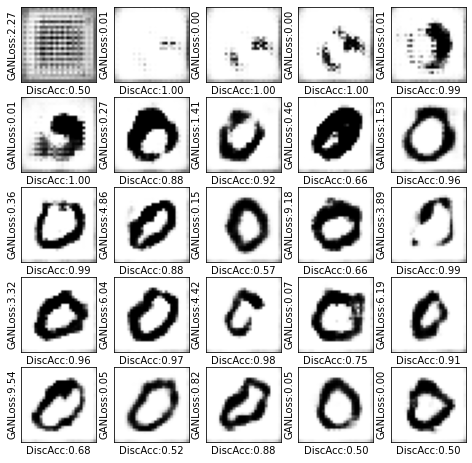

In [29]:
%%time
#Writing our training loop
epochs = 25
batch_size = 128 #Same batch size used in the original DCGAN paper
steps_per_epoch = int(2 * x.shape[0]/batch_size) #steps to go roughly through all the images
#Created some randomly generated examples from teh generator and we'll also take some of the true examples from the actual dataset we have.
#And some of those examples and some of the randomly generated examples will be club together to create a training batch for our network 

#Now once those batchs are created, we have the labels for which are the real images and fake generated images
#And we will set our discriminator to trainable and train it on that batch and then will not train the discriminator but train the GAN network.
#When we train the GAN, essentially what we want is set the labels all to classification that will set for real images. 0 for real and 1 for fake images.
#So that way, the artist or the generator is forced to move in a direction which will try to achieve those labels for that batch and we keep doing this for a while and we'll start to see better images generated by the generator.

print('Steps per epoch=', steps_per_epoch)
#In each training step, only half of the real images are used and that's the reason why we're multiplying the no. of examples by 2 when calculating no. of steps for epoch.

#If you want to look to tfutils code, go to https://github.com/am1tyadav/tfutils
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8)) #5 rows, 5 cols, image size of 8X8
#Using this plot to look at our generators output after each epoch
for e in range(0, epochs):
    
    dp.start_of_epoch(e) #need to specify the start_of_epoch in dynamic plot which will be used to create subplot
    
    for step in range(0, steps_per_epoch): #0-106
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)] #batchsize/2 bcoz we only need half of the true examples
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1)) #reshaped to add the additional dimension here for channel which doesn't exist in the original dataset. => true_examples.shape[0] as batch size.

        noise = np.random.randn(int(batch_size/2), noise_dim) #noise_dim = 1
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0) #Row wise concatenation
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2)) #need to create the labels as well. For the fake images, we will use 0 (64 zeros) and 1 (64 ones) 

        indices = np.random.choice(range(batch_size), batch_size, replace=False) #Randomizing the order returning these many indices as batch_size, not wanting any of the indices to repeat
        x_batch = x_batch[indices] #Hence, randomizing
        y_batch = y_batch[indices] #Hence, randomizing

        #Train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        #Since, we are going to train the entire network, set discriminator.trainable = False
        #Train the generator to create images which will get the o/p 1 for all the images.
        #So, let's train the GAN
        #must predict 1's for the real images generated by the generators trained above since discriminator is False.
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1))) #noise as i/p and labels as list of ones or batchsize/2 since it's the dimensions of noise. #Tuple
        
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False) #Performance of the generator
        #When the accuracy is high, the discriminator is doing well but as the model trains more and more, this will also be the indicative of the generator because when the generator does well, the discriminator accuracy will reduce.

    noise = np.random.randn(1, noise_dim) #For each epoch, essentially we want to generate only the first example which is just the only 1  
    generated_example = generator.predict(noise)[0]
    
    dp.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary',
                   'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))
    #When the generator performs well the discriminator accuracy starts going down significantly.
    #But the discriminator is also learning to perform better at each step and generator is also trying to do the same.
    #By the end of 25 generated images/epochs, you will start to see pretty descent zeroes in the output, and if you train it more, these will get better.  